In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd
from cuml.manifold.umap import UMAP as cumlUMAP
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### load data

In [3]:
DATASET_ID = 'katahira_white_munia_segmented'
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'munia.pickle'

In [4]:
syllable_df = pd.read_pickle(df_loc)
del syllable_df['audio']

In [5]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,rate,spectrogram
0,1.17,1.182,WM24,0,WM24_11,48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1.19,1.200,WM24,0,WM24_11,48000,"[[0, 0, 0, 0, 0, 0, 0, 19, 9, 2, 0, 0, 3, 5, 0..."
2,1.77,1.802,WM24,0,WM24_11,48000,"[[0, 0, 0, 0, 0, 0, 7, 7, 0, 0, 0, 0, 0, 0, 0,..."


In [6]:
np.shape(syllable_df.spectrogram.values[0])

(32, 22)

### project

In [7]:
ensure_dir(DATA_DIR / 'embeddings' / DATASET_ID / 'full')

(147, 704) WM24


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  # Remove the CWD from sys.path while we load stuff.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  # This is added back by InteractiveShellApp.init_path()


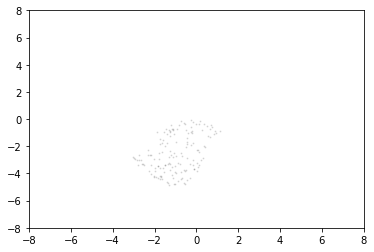

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(3308, 704) WM33


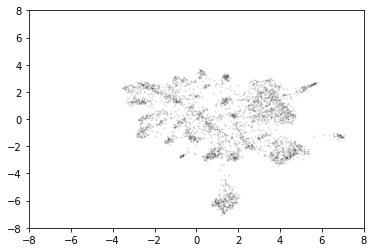

(1285, 704) WM19


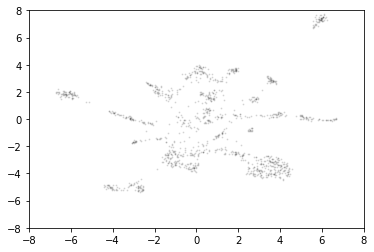

(3734, 704) WM27


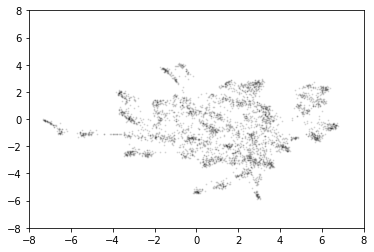

(598, 704) WM25


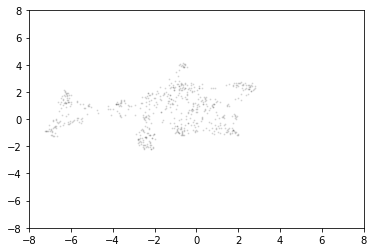

(2889, 704) WM44


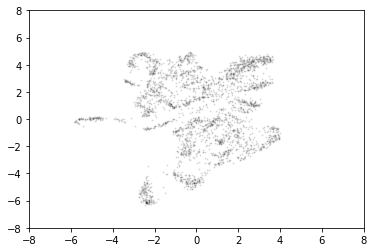

(3468, 704) WM31


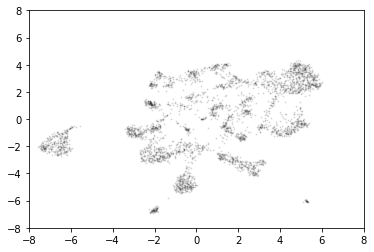

(1669, 704) WM06


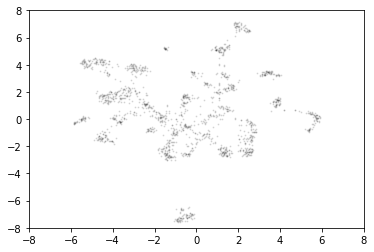

(2214, 704) WM37


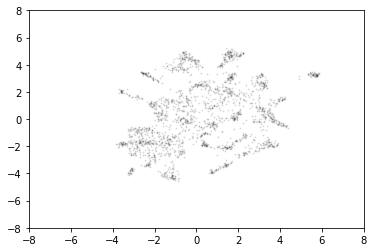

(2077, 704) WM30


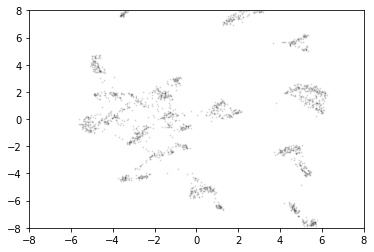

(3551, 704) WM26


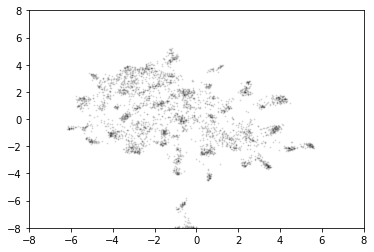

(2068, 704) WM10


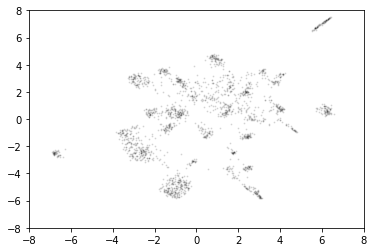

(5117, 704) WM36


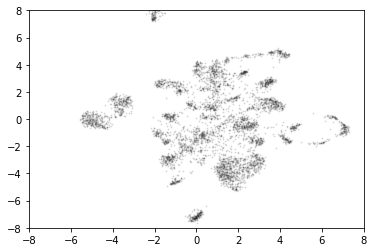

(2446, 704) WM03


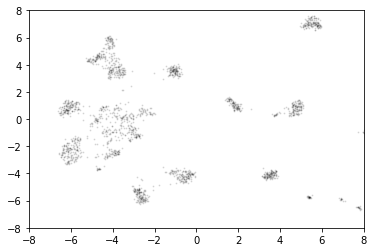

(2234, 704) WM15


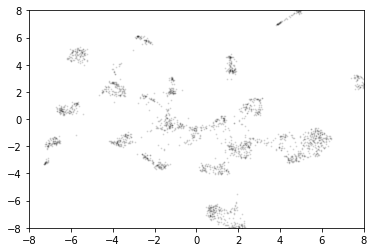

(1902, 704) WM28


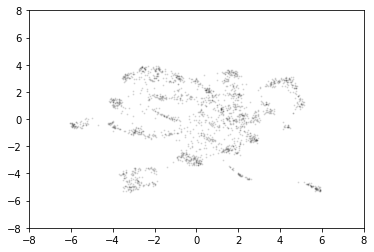

(4946, 704) WM32


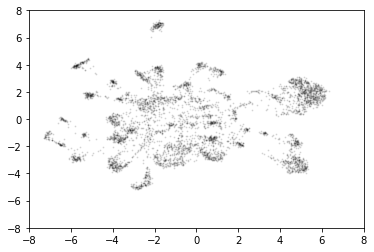

(4580, 704) WM39


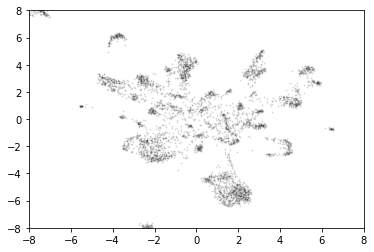

(2346, 704) WM04


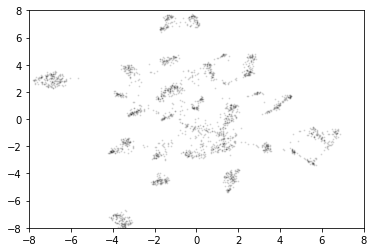

(3160, 704) WM29


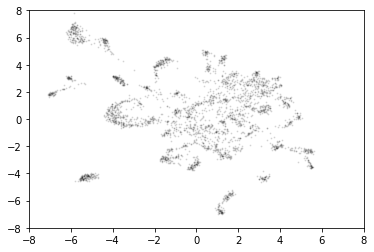

(3039, 704) WM34


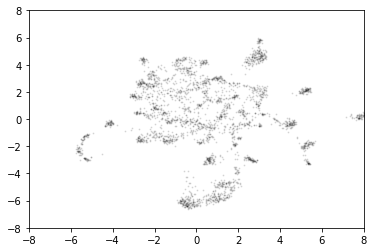

(1799, 704) WM12


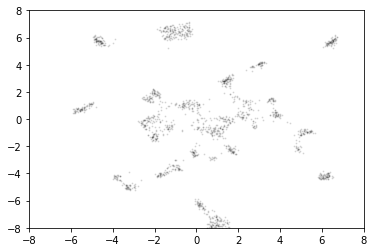

(1306, 704) WM09


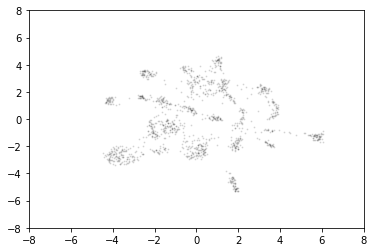

(2290, 704) WM35


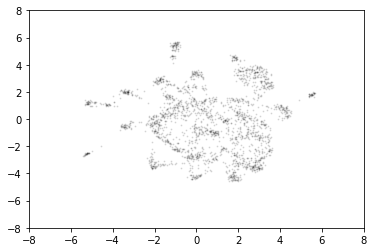

(5647, 704) WM38


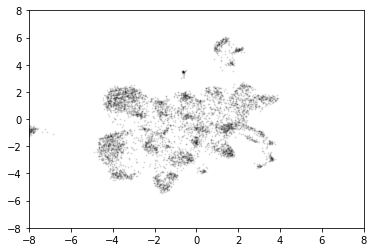

(1663, 704) WM23


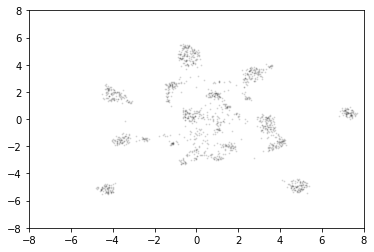

(1533, 704) WM14


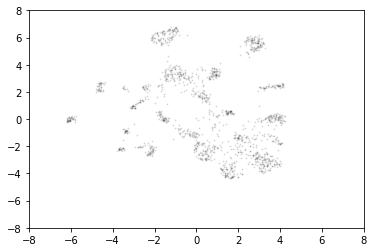

(2393, 704) WM42


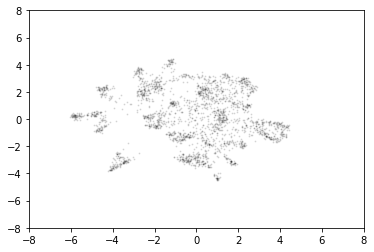

(1966, 704) WM02


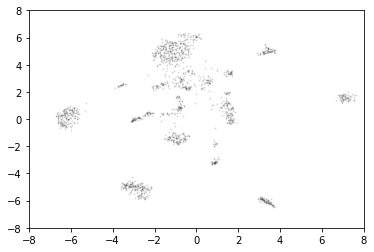

(1898, 704) WM07


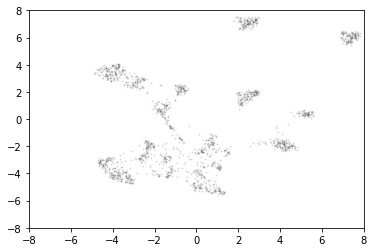

(2542, 704) WM21


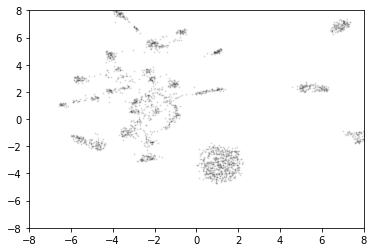

(2515, 704) WM16


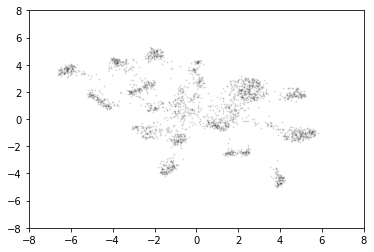

(9190, 704) WM40


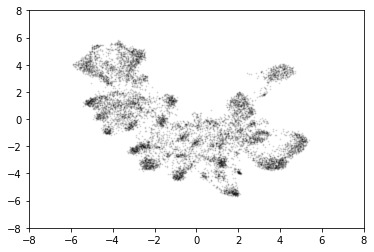

(1353, 704) WM18


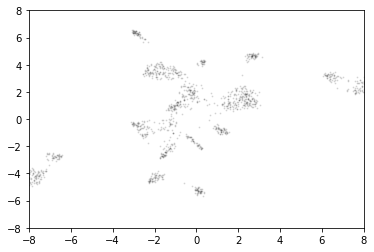

(1501, 704) WM43


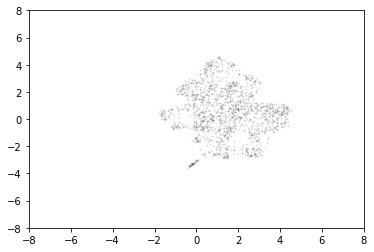

(790, 704) WM22


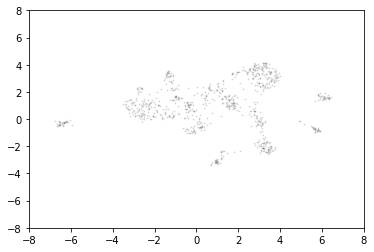

(2073, 704) WM41


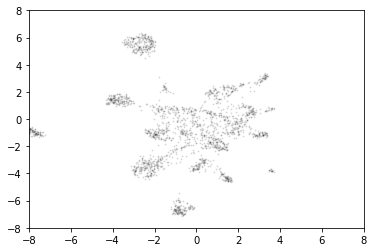

(2389, 704) WM01


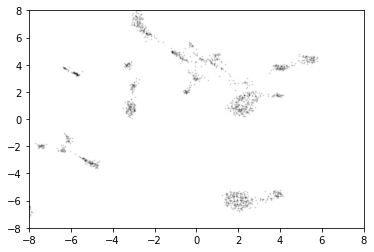

(1674, 704) WM17


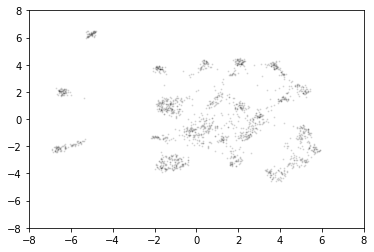

(1712, 704) WM20


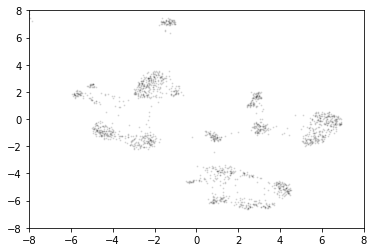

(2664, 704) WM11


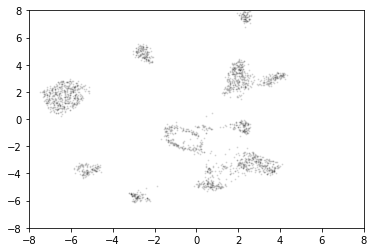

(1538, 704) WM13


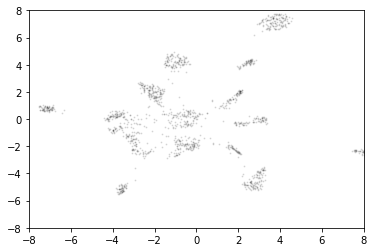

(2224, 704) WM08


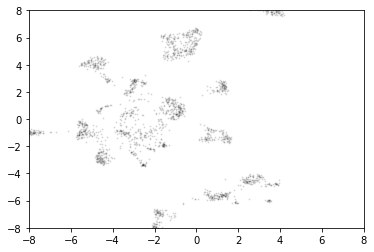

(2062, 704) WM05


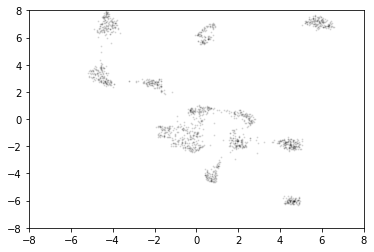

In [12]:
for indv in tqdm(syllable_df.indv.unique()):
    subset_df = syllable_df[syllable_df.indv == indv]
    
    specs = list(subset_df.spectrogram.values)
    specs = [i/np.max(i) for i in tqdm(specs)]
    specs_flattened = flatten_spectrograms(specs)
    print(np.shape(specs_flattened), indv)
    
    min_dist = 0.5
    cuml_umap = cumlUMAP(min_dist = min_dist)
    embedding = cuml_umap.fit_transform(specs_flattened)
    
    fig, ax = plt.subplots()
    ax.scatter(embedding[:,0], embedding[:,1], s=1, color='k', alpha = 0.1)
    ax.set_xlim([-8,8])
    ax.set_ylim([-8,8])
    plt.show()
    
    subset_df['umap'] = list(embedding)
    subset_df.to_pickle(DATA_DIR / 'embeddings' / DATASET_ID / (str(min_dist) + '_' + indv + '.pickle'))